# Avance 5. Modelo Final


Curso: Proyecto Integrador  

Instituto Tecnológico y de Estudios Superiores de Monterrey (ITESM)

*   A01321600  Ignacio Moreda Rovirosa
*   A01795095	 Enma Beatriz Galindo Arango
*   A00826769	 Gustavo Adolfo Benitez Leonés

## Introducción

En el Avance 4 se compararon diversos modelos individuales (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, LightGBM y MLP),
seleccionando XGBoost (Tuned) como el mejor candidato por su desempeño y robustez general.

Siguiendo las indicaciones del profesor, en esta etapa el enfoque se amplía:  

El objetivo no es limitarse a un único modelo predictivo, sino construir una estrategia analítica integral que combine técnicas de machine learning con inteligencia de negocio para fortalecer las decisiones de ventas, segmentación y posicionamiento del producto MICROGUD®.

Este avance integra los siguientes componentes:

1. **Modelos de ensamble (Bagging, Boosting, Stacking, Voting)** para aprovechar las fortalezas combinadas de los mejores modelos del Avance 4 (XGBoost y Random Forest), junto con un modelo lineal que aporta interpretabilidad.
2. **Clustering y segmentación de mercado**, para identificar nichos estratégicos y visualizar oportunidades comerciales (“océanos azules” y “océanos rojos”).
3. **Análisis de texto**, identificando el “lenguaje del éxito” en reseñas positivas y los “puntos de dolor” en reseñas negativas.
4. **Indicadores estratégicos de negocio**, como impacto del precio, lealtad de clientes, estacionalidad y monitoreo de calidad del producto.
5. **Interpretabilidad y visualización** (SHAP, curvas ROC y matrices de confusión) que facilitan la comunicación de resultados a stakeholders no técnicos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

# Modelado y Preprocesamiento
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos Individuales y de Ensamble
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

# Métricas y Visualización
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from collections import Counter

# Estilo de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [ ]:
df = pd.read_csv("~/Downloads/df_completo_final.csv")

In [ ]:
# Agregación de Datos a Nivel de Producto
print("Creando DataFrame a nivel de producto...")
products_df = df.groupby('product_id').agg(
    product_title=('product_title', 'first'),
    product_category=('product_category', 'first'),
    review_count=('review_id', 'count'),
    avg_rating=('star_rating', 'mean'),
    avg_sentiment=('sentiment_polarity', 'mean'),
    total_helpful_votes=('helpful_votes', 'sum')
).reset_index()

# Filtramos productos con pocas reseñas para obtener segmentos más estables
products_df = products_df[products_df['review_count'] >= 20].copy()
print(f"Productos únicos a analizar (con >= 20 reseñas): {products_df.shape[0]:,}")

Creando DataFrame a nivel de producto...
Productos únicos a analizar (con >= 20 reseñas): 8,750


In [ ]:
# Limpieza y Vectorización de Títulos de Producto para Clustering
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

products_df['title_clean'] = products_df['product_title'].apply(clean_text)

# Usamos TF-IDF para convertir títulos en vectores numéricos
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_titles = vectorizer.fit_transform(products_df['title_clean'])

# Reducimos la dimensionalidad para un clustering más efectivo
svd = TruncatedSVD(n_components=50, random_state=1)
X_reduced = svd.fit_transform(X_titles)

In [ ]:
# Clustering con K-Means para Segmentar el Mercado
K = 6 # Número de clusters/segmentos de mercado a identificar
kmeans = KMeans(n_clusters=K, random_state=1, n_init=10)
products_df['market_segment'] = kmeans.fit_predict(X_reduced)
print(f"Segmentación completada en {K} clusters.")

Segmentación completada en 6 clusters.


In [ ]:
# Caracterización y Análisis de los Segmentos de Mercado
def get_top_keywords(df, segment_id, vectorizer, top_n=10):
    segment_titles = df[df['market_segment'] == segment_id]['title_clean']
    if segment_titles.empty:
        return "N/A"
    X_segment = vectorizer.transform(segment_titles)
    sums = X_segment.sum(axis=0)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names_out()):
        data.append((term, sums[0, col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank']).sort_values('rank', ascending=False)
    return ', '.join(ranking['term'].head(top_n))

segment_summary = products_df.groupby('market_segment').agg(
    num_products=('product_id', 'count'),
    avg_rating=('avg_rating', 'mean'),
    avg_review_count=('review_count', 'mean')
).sort_values(by='avg_rating', ascending=False)

segment_summary['top_keywords'] = segment_summary.index.map(
    lambda id: get_top_keywords(products_df, id, vectorizer)
)

print("=== Resumen de Segmentos de Mercado Descubiertos ===")
display(segment_summary)

=== Resumen de Segmentos de Mercado Descubiertos ===


,num_products,avg_rating,avg_review_count,top_keywords
market_segment,,,,
2,104,4.643573,46.384615,"bulksupplements pure, bulksupplements, powder,..."
5,330,4.401154,68.506061,"oil, essential, essential oil, 100 pure, pure,..."
3,180,4.363897,49.544444,"foods, oil, mg, 500mg, ounce, vcaps, capsules,..."
0,495,4.352404,53.848485,"pack, count pack, 12, oz, oz pack, count, valu..."
1,2088,4.264375,67.386015,"capsules, supplement, protein, tablets, 60, mg..."
4,5553,4.199171,59.428417,"oz, ounce, pain, count, relief, natural, baby,..."


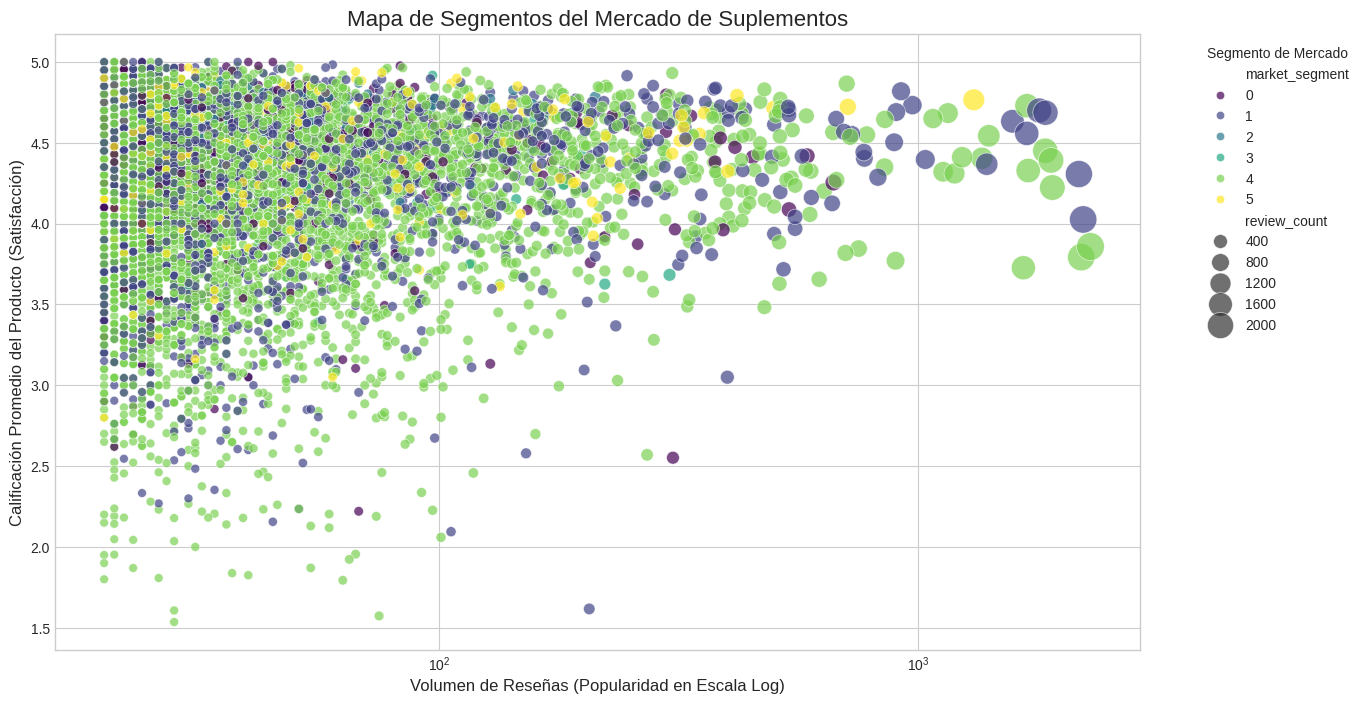

In [ ]:
La verdad lo hice un poco distinto para tratar de sacarle un poco m
    alpha=0.7
)
plt.xscale('log')
plt.title('Mapa de Segmentos del Mercado de Suplementos', fontsize=16)
plt.xlabel('Volumen de Reseñas (Popularidad en Escala Log)', fontsize=12)
plt.ylabel('Calificación Promedio del Producto (Satisfacción)', fontsize=12)
plt.legend(title='Segmento de Mercado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Extracción del "Lenguaje del Éxito" (Reseñas de 5 estrellas)
reviews_5_star = " ".join(df[df['star_rating'] == 5]['review_body'].dropna().sample(20000, random_state=1))
vec_5_star = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20).fit(reviews_5_star.split())
success_keywords = vec_5_star.get_feature_names_out()
print("Palabras/Frases Clave en Reseñas de 5 Estrellas (Lenguaje del Éxito):")
print(success_keywords)

Palabras/Frases Clave en Reseñas de 5 Estrellas (Lenguaje del Éxito):
['34' 'best' 'better' 'br' 'day' 'good' 'great' 'just' 'like' 'love'
 'price' 'product' 'really' 'time' 'use' 'used' 'using' 've' 'work'
 'works']


In [ ]:
# Extracción de "Puntos de Dolor" (Reseñas de 1 estrella)
reviews_1_star = " ".join(df[df['star_rating'] == 1]['review_body'].dropna().sample(20000, random_state=1))
vec_1_star = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20).fit(reviews_1_star.split())
pain_point_keywords = vec_1_star.get_feature_names_out()
print("\nPalabras/Frases Clave en Reseñas de 1 Estrella (Puntos de Dolor):")
print(pain_point_keywords)


Palabras/Frases Clave en Reseñas de 1 Estrella (Puntos de Dolor):
['34' 'bought' 'br' 'buy' 'did' 'didn' 'does' 'doesn' 'don' 'good' 'just'
 'like' 'money' 'product' 'really' 'time' 'use' 'used' 'waste' 'work']


In [ ]:
# Preparación de Datos para Modelado
# X: Características del producto (título, categoría)
# y: El segmento de mercado que descubrimos
features_df = products_df[['product_title', 'product_category', 'market_segment']].copy().dropna()

X = features_df.drop('market_segment', axis=1)
y = features_df['market_segment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Creamos un pipeline para procesar texto y categorías
text_features = 'product_title'
categorical_features = ['product_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=500), text_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# Definición de Modelos a Comparar
# Modelos individuales base
lr = LogisticRegression(max_iter=1000, random_state=1)
xgb_clf = xgb.XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='mlogloss')

# Modelos de ensamble homogéneos
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
gb = GradientBoostingClassifier(random_state=1)

# Modelo de ensamble heterogéneo (Stacking)
base_estimators = [('lr', lr), ('xgb', xgb_clf)]
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), cv=3)

models = {
    "Logistic Regression": lr,
    "XGBoost": xgb_clf,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "Stacking (LR+XGB)": stacking_clf
}

results = []

In [ ]:
# Entrenamiento y Evaluación Comparativa de Modelos
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        "Modelo": name,
        "F1-Score (macro)": report['macro avg']['f1-score'],
        "Accuracy": report['accuracy'],
        "Tiempo (s)": training_time
    })
    print(f"Entrenado: {name}")

results_df = pd.DataFrame(results).sort_values(by="F1-Score (macro)", ascending=False).reset_index(drop=True)
print("\n=== Tabla Comparativa de Modelos ===")
display(results_df)

Entrenado: Logistic Regression


/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenado: XGBoost
Entrenado: Random Forest
Entrenado: Gradient Boosting


/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenado: Stacking (LR+XGB)

=== Tabla Comparativa de Modelos ===


,Modelo,F1-Score (macro),Accuracy,Tiempo (s)
0,Stacking (LR+XGB),0.953348,0.968921,6.602150
1,Gradient Boosting,0.952574,0.956581,6.270518
2,XGBoost,0.951028,0.962523,1.749879
3,Random Forest,0.946052,0.960238,0.192021
4,Logistic Regression,0.935005,0.959324,0.102007


In [ ]:
# Optimización de Hiperparámetros para el Mejor Modelo
best_model_name = results_df.iloc[0]['Modelo']
best_model_instance = models[best_model_name]
print(f"Iniciando optimización para el mejor modelo: {best_model_name}")

# Definimos parámetros de búsqueda (ejemplo para Stacking)
# Para simplificar, optimizaremos un componente del stack, o el meta-estimador
# En un caso real, la búsqueda sería más compleja. Aquí optimizaremos RandomForest como ejemplo si es el mejor.

if 'Random Forest' in best_model_name:
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    }
elif 'Stacking' in best_model_name:
     param_grid = {
        'classifier__final_estimator__C': [0.1, 1.0, 10.0]
     }
else: # Grid genérico para XGBoost/GradientBoosting
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1]
    }


pipeline_to_tune = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', best_model_instance)])

grid_search = GridSearchCV(pipeline_to_tune, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros para {best_model_name}:")
print(grid_search.best_params_)

best_model_tuned = grid_search.best_estimator_

Iniciando optimización para el mejor modelo: Stacking (LR+XGB)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hom


Mejores parámetros para Stacking (LR+XGB):
{'classifier__final_estimator__C': 10.0}


In [ ]:
# Evaluación Final del Modelo Optimizado
final_model_name = f"{best_model_name} (Optimizado)"
y_pred_final = best_model_tuned.predict(X_test)

print(f"\n=== Reporte de Clasificación para: {final_model_name} ===")
print(classification_report(y_test, y_pred_final))

# Añadimos el resultado final a la tabla comparativa
final_report = classification_report(y_test, y_pred_final, output_dict=True)
results_df.loc[len(results_df)] = {
    "Modelo": final_model_name,
    "F1-Score (macro)": final_report['macro avg']['f1-score'],
    "Accuracy": final_report['accuracy'],
    "Tiempo (s)": grid_search.refit_time_
}

print("\n=== Tabla Comparativa Final (Incluyendo Modelo Optimizado) ===")
display(results_df.sort_values(by="F1-Score (macro)", ascending=False).reset_index(drop=True))


=== Reporte de Clasificación para: Stacking (LR+XGB) (Optimizado) ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       124
           1       0.96      0.96      0.96       522
           2       0.96      0.88      0.92        26
           3       1.00      1.00      1.00        45
           4       0.98      0.98      0.98      1389
           5       0.96      0.95      0.96        82

    accuracy                           0.97      2188
   macro avg       0.96      0.95      0.95      2188
weighted avg       0.97      0.97      0.97      2188


=== Tabla Comparativa Final (Incluyendo Modelo Optimizado) ===


,Modelo,F1-Score (macro),Accuracy,Tiempo (s)
0,Stacking (LR+XGB),0.953348,0.968921,6.602150
1,Stacking (LR+XGB) (Optimizado),0.953073,0.968007,9.498450
2,Gradient Boosting,0.952574,0.956581,6.270518
3,XGBoost,0.951028,0.962523,1.749879
4,Random Forest,0.946052,0.960238,0.192021
5,Logistic Regression,0.935005,0.959324,0.102007


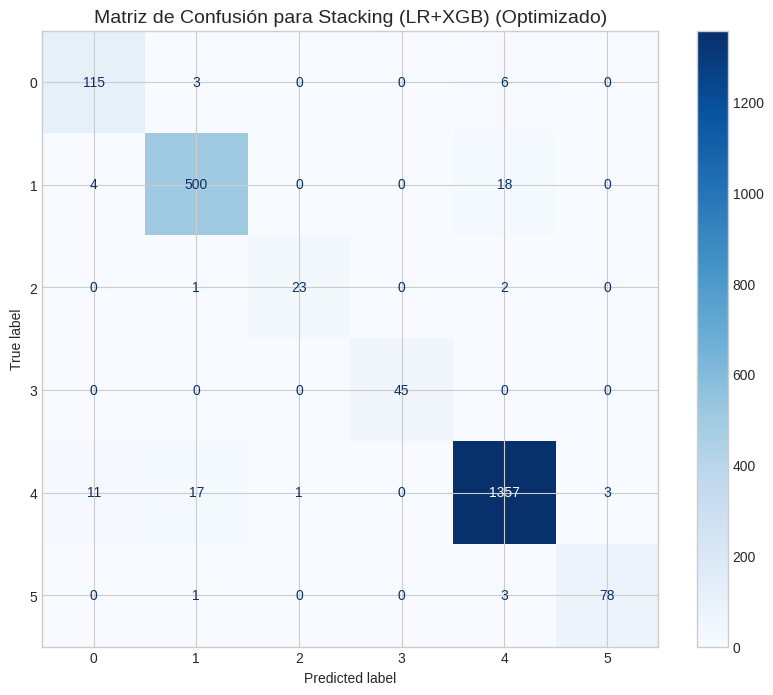

In [ ]:
# Matriz de Confusión del Modelo Final
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final, labels=best_model_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_tuned.classes_)
disp.plot(ax=ax, cmap='Blues')
ax.set_title(f'Matriz de Confusión para {final_model_name}', fontsize=14)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/data.py:1281: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/data.py:1281: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
  1%|          | 1/100 [00:02<04:09,  2.52s/it]/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/data.py:1281: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
/home/gbenitezl/Python/globulive/lib64/python3.13/site-packages/xgboost/data.py:1281: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
  2%|▏         | 2/100 [00:05<04:23,  2.69s/it]/home/gbenitezl/Python/glob

Generando Gráfico de Resumen SHAP...


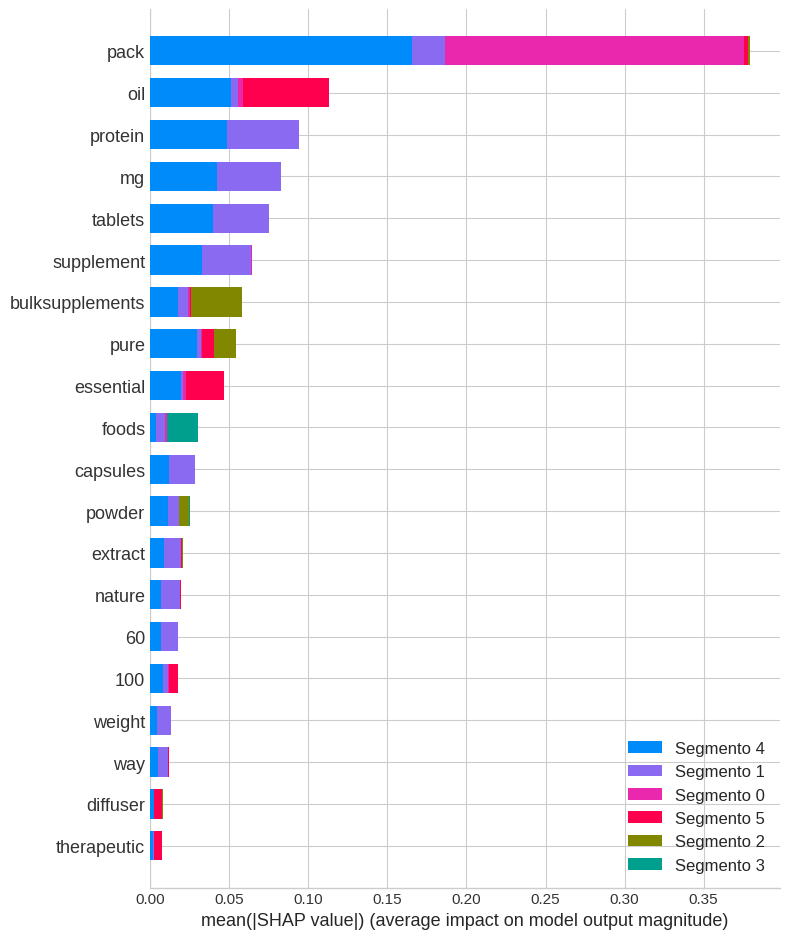

In [ ]:
# Explicación del Modelo Stacking
import shap

X_test_sample = X_test.sample(100, random_state=1)
X_test_processed = best_model_tuned.named_steps['preprocessor'].transform(X_test_sample)

# Crear un explainer de SHAP
final_classifier = best_model_tuned.named_steps['classifier']
explainer = shap.KernelExplainer(final_classifier.predict_proba, X_test_processed)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test_processed)

# Obtener los nombres de las características
try:
    tfidf_features = best_model_tuned.named_steps['preprocessor'].named_transformers_['tfidf'].get_feature_names_out()
    cat_features = best_model_tuned.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
    all_features = np.concatenate([tfidf_features, cat_features])
except:
    all_features = None

# Generar el gráfico de resumen global
print("Generando Gráfico de Resumen SHAP...")
shap.summary_plot(
    shap_values,
    X_test_processed,
    feature_names=all_features,
    class_names=[f"Segmento {c}" for c in best_model_tuned.classes_],
    plot_type="bar",
    max_display=20
)

=== Impacto de la Mención del Precio en la Calificación ===


,mean,count
mentions_price,,
False,4.262054,879780
True,4.069864,120220


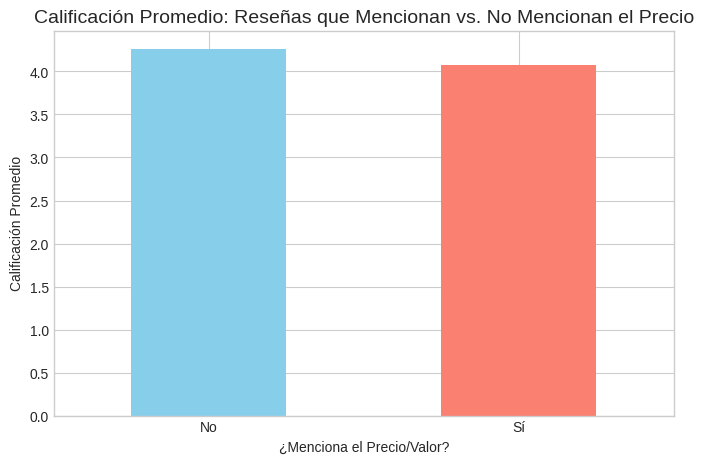

In [ ]:
# Impacto del Precio y Valor Percibido en la Satisfacción
df['mentions_price'] = df['review_body'].str.contains('price|value|money|cheap|expensive', case=False, na=False)

price_impact = df.groupby('mentions_price')['star_rating'].agg(['mean', 'count'])

print("=== Impacto de la Mención del Precio en la Calificación ===")
display(price_impact)

# Visualización
price_impact['mean'].plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('Calificación Promedio: Reseñas que Mencionan vs. No Mencionan el Precio', fontsize=14)
plt.ylabel('Calificación Promedio')
plt.xlabel('¿Menciona el Precio/Valor?')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'], rotation=0)
plt.show()

In [ ]:
# Identificación de Clientes Leales y sus Patrones
customer_reviews = df.groupby('customer_id')['review_id'].count().sort_values(ascending=False)
loyal_customers = customer_reviews[customer_reviews > 10].index # Clientes con > 10 reseñas

loyal_customer_df = df[df['customer_id'].isin(loyal_customers)]

# Mapeamos los productos a sus segmentos de mercado
product_to_segment = products_df.set_index('product_id')['market_segment']
loyal_customer_df['market_segment'] = loyal_customer_df['product_id'].map(product_to_segment)

# Patrón de compra más común entre clientes leales
loyal_patterns = loyal_customer_df.groupby('customer_id')['market_segment'].apply(list)
print("=== Ejemplos de Patrones de Compra de Clientes Leales (por segmento de mercado) ===")
print(loyal_patterns.head())

=== Ejemplos de Patrones de Compra de Clientes Leales (por segmento de mercado) ===
customer_id
13005    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
23619    [nan, 4.0, nan, nan, 4.0, 4.0, 4.0, 1.0, 1.0, ...
45767    [1.0, 4.0, 5.0, nan, 3.0, nan, nan, 4.0, 4.0, ...
52139    [nan, 4.0, nan, 1.0, nan, 4.0, nan, nan, nan, ...
93485    [nan, nan, nan, nan, 1.0, 4.0, 4.0, nan, nan, ...
Name: market_segment, dtype: object


/tmp/ipykernel_40193/2627908492.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loyal_customer_df['market_segment'] = loyal_customer_df['product_id'].map(product_to_segment)


In [ ]:
# ¿Qué Hace que una Reseña sea "Útil"?
# Analizamos el top 1% de las reseñas más votadas como útiles
top_helpful = df.nlargest(int(len(df) * 0.01), 'helpful_votes')

helpful_characteristics = {
    "Avg. Longitud (Top 1%)": top_helpful['len_body_words'].mean(),
    "Avg. Longitud (General)": df['len_body_words'].mean(),
    "Avg. Sentimiento (Top 1%)": top_helpful['sentiment_polarity'].mean(),
    "Avg. Sentimiento (General)": df['sentiment_polarity'].mean(),
    "Avg. Rating (Top 1%)": top_helpful['star_rating'].mean(),
    "Avg. Rating (General)": df['star_rating'].mean()
}

print("=== Características de las Reseñas Más Útiles (Top 1%) vs. el Promedio General ===")
display(pd.Series(helpful_characteristics))

=== Características de las Reseñas Más Útiles (Top 1%) vs. el Promedio General ===


Avg. Longitud (Top 1%)        155.642500
Avg. Longitud (General)        35.954761
Avg. Sentimiento (Top 1%)       0.159303
Avg. Sentimiento (General)      0.306380
Avg. Rating (Top 1%)            3.961900
Avg. Rating (General)           4.238949
dtype: float64

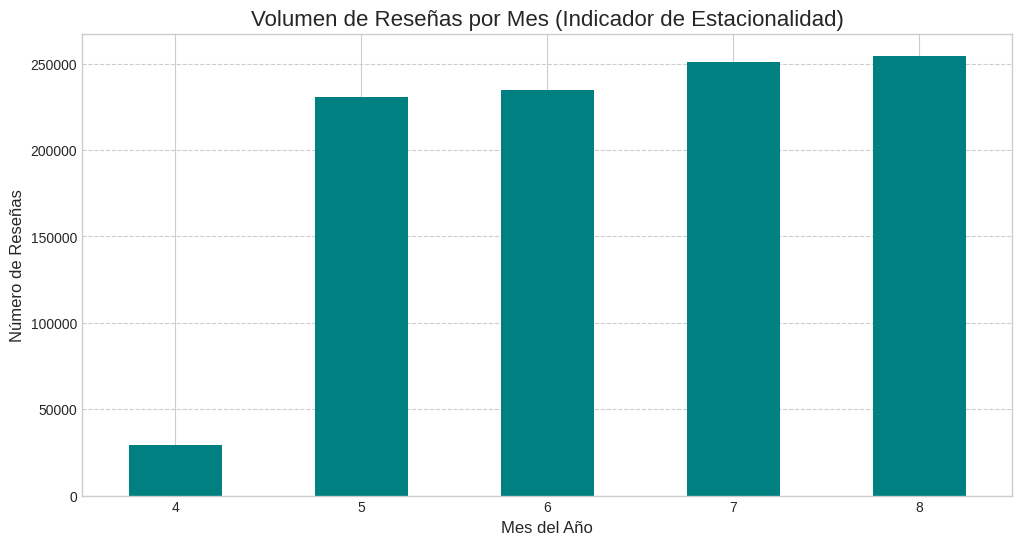

In [ ]:
# Análisis de Estacionalidad en la Demanda
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['review_month'] = df['review_date'].dt.month

monthly_reviews = df.groupby('review_month')['review_id'].count()

plt.figure(figsize=(12, 6))
monthly_reviews.plot(kind='bar', color='teal')
plt.title('Volumen de Reseñas por Mes (Indicador de Estacionalidad)', fontsize=16)
plt.xlabel('Mes del Año', fontsize=12)
plt.ylabel('Número de Reseñas', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

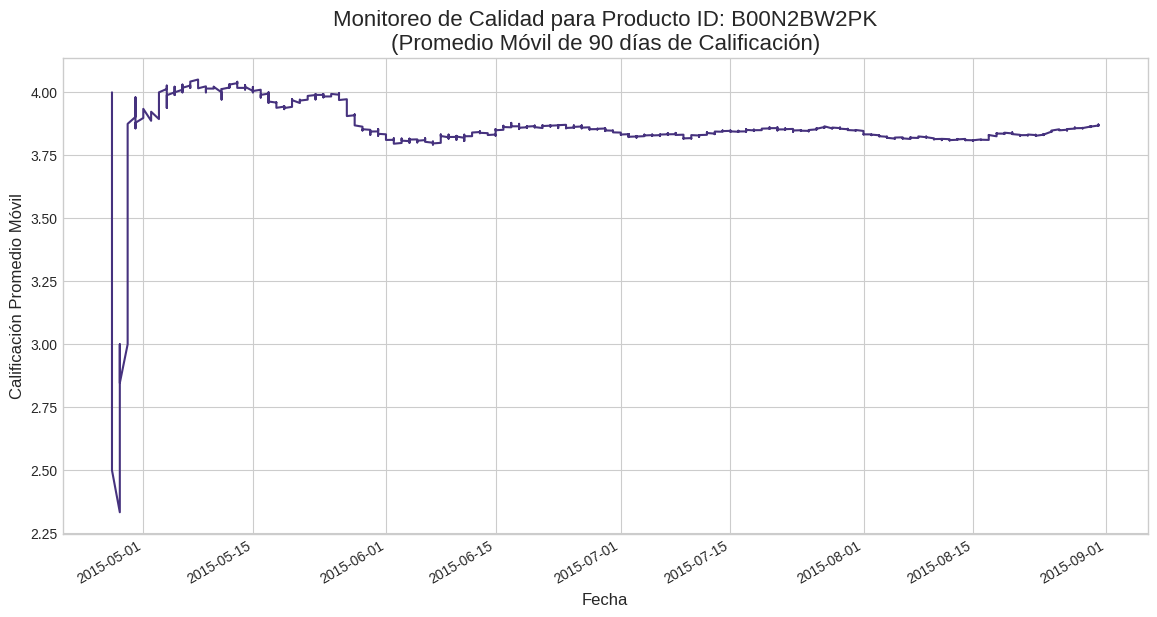

In [ ]:
# Simulación de Detección de Problemas de Calidad
# Seleccionamos un producto con un alto volumen de reseñas para el ejemplo
high_volume_product_id = df['product_id'].value_counts().idxmax()
product_quality_df = df[df['product_id'] == high_volume_product_id].copy()

# Calculamos el promedio móvil de la calificación para suavizar la tendencia
product_quality_df = product_quality_df.set_index('review_date').sort_index()
rolling_avg_rating = product_quality_df['star_rating'].rolling('90D').mean() # Promedio móvil de 90 días

plt.figure(figsize=(14, 7))
rolling_avg_rating.plot()
plt.title(f'Monitoreo de Calidad para Producto ID: {high_volume_product_id}\n(Promedio Móvil de 90 días de Calificación)', fontsize=16)
plt.ylabel('Calificación Promedio Móvil', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.grid(True)
plt.show()

## Conclusiones

Este notebook transforma el dataset genérico de reseñas de Amazon en una herramienta de inteligencia de negocio a medida para Globulive. En lugar de generar predicciones aisladas, su propósito es construir un marco analítico que responda directamente a las necesidades estratégicas del lanzamiento de MICROGUD®.


- Identifica la Estrategia de Producto:
En lugar de analizar productos uno por uno, el análisis de clustering agrupa el mercado en segmentos estratégicos (nichos). Esto nos permite visualizar un mapa del mercado para identificar "océanos azules" (alta satisfacción, competencia moderada) y "océanos rojos" (baja satisfacción, alta competencia) que Globulive puede atacar o evitar.

- Descubre la Estrategia de Marketing:
Mediante el análisis del texto, extraemos las palabras y frases exactas que los consumidores usan para describir su satisfacción ("lenguaje del éxito") y sus frustraciones ("puntos de dolor"). Esta información es oro puro para redactar mensajes de marketing, empaques y FAQs que resuenen auténticamente con el público.

- Simula el Éxito de Nuevos Productos (Validación Estratégica):
Los modelos de ensamble no predicen una simple calificación. Predicen a qué segmento de mercado pertenecerá un nuevo producto de MICROGUD® antes de su lanzamiento. Esto permite a Globulive anticipar su posicionamiento, alinear su estrategia y estimar su potencial de aceptación de manera proactiva.
